## Задание 2. Изучение свойств и харктеристик валютных ПФИ и инструментов денежного рынка

## Цель задания:
### 1. Изучить свойства и особенности ценообразования процентного свопа
### 1. Изучить свойства и особенности ценообразования валютного свопа
### 2. Получить навыки работы с моделями валютных опционов

## 1. Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
from __future__ import division

In [3]:
import matplotlib.pyplot as plt

In [4]:
from collections import OrderedDict 

In [5]:
import matplotlib.pyplot as plt 

In [6]:
import warnings
warnings.filterwarnings('ignore')

## 2. Полезные функции

In [7]:
# создание массива процентных ставок
def rates_y(term,s_t,f,start_r,step_r):
    end=int(term*f)
    rates=[start_r+step_r*i for i in range(0,end)]
    return OrderedDict(zip([i for i in np.arange(s_t,term*f,1/freq)],rates))

In [8]:
# расчет форвардных курсов
def forward_ex_rate(rates_A,rates_B,ex_rate,freq):
    n=len(rates_A)
    l=[]
    for key in rates_A:
        l.append(ex_rate*(((1+rates_B[key]/freq)/(1+rates_A[key]/freq))**(key*freq)))
       #l.append(ex_rate*(np.exp((rates_B[key]-rates_A[key])*key)))
    return OrderedDict(zip(rates_A.keys(),l))   

In [9]:
step_rate=0.000 ## шаг изменения процентных ставок (везде принимаем равным 0)

In [10]:
freq=2 ##частота выплаты купона и начисления процентов для дисконтирования (везде принимаем равной 0.5, 2 раза в год)

In [11]:
start_time=0.5 ## время первой выплаты в годах (везде принимаем равной 0.5, через 6 месяцев)

## 3. Interest Rate Swap (Процентный своп)

### Класс, содержащий методы для моделирования свопа

In [12]:
class Swap:
        def __init__(self,nominal,m,rates): # инициализация нового свопа
            self._rates=rates
            self._term=list(rates.keys())[len(rates)-1]
            self._nominal=nominal
            self._m=m # частота выплат
            self._new=True
  
        def __discount__(self): # расчет ставок дисконтирования
            l=[]
            for key in self._rates:
                l.append(1/(1+self._rates[key]/self._m)**(self._m*key))
            self._DF=OrderedDict(zip(self._rates.keys(),l))
            
        def __coupon_rate__(self):# расчет фиксированной ставки (купона облигации)
            self.__discount__()
            c=(self._nominal-self._nominal*self._DF[self._term])/sum(self._DF.values())
            self._coupon =OrderedDict(zip(self._DF.keys(),np.repeat(c,len(self._DF))))
            self._new=False
            
        def __bond_value__(self,c):# расчет цены облигации
            self.__discount__()
            self._bond=(self._nominal*self._DF[self._term]+(sum([c[key]*self._DF[key] for key in self._DF])))
       
        def __float_leg__(self):# расчет стоимости плавающей части
            self.__discount__()
            self._Float =(self._nominal+self._nominal*list(list(self._rates.values()))[0]/self._m)*list(self._DF.values())[0] 
                         
        def __forward_rates__(self):# расчет форвардных ставок
            n=len(self._rates)
            l=[]
            l.append(list(self._rates.values())[0])
            for i in range(1,n):
                 l.append(((1+list(self._rates.values())[i])**list(self._rates.keys())[i]/(1+list(self._rates.values())[i-1])**list(self._rates.keys())[i-1])**(1/(list(self._rates.keys())[i]-list(self._rates.keys())[i-1]))-1)
            self._forward=OrderedDict(zip(self._rates.keys(),l))
        
        def __fix_leg__(self):# расчет стоимости фиксированной части
            if self._new==True:
                self.__coupon_rate__()
            self.__bond_value__(self._coupon)
            self._Fix=self._bond

        def get_fix_leg(self):# получить стоимости фиксированной части
            self.__fix_leg__()
            return self._Fix
        
        def get_float_leg(self):# получить стоимости плавающей части
            self.__float_leg__()
            return self._Float
       
        def get_fix_rate(self):# получить фиксированную ставку
            if self._new==True:
                self.__coupon_rate__()
            return self._coupon
        
        def get_swap_value(self):# получить стоимости свопа
            self.__fix_leg__()
            self.__float_leg__()
            return np.round(self._Float-self._Fix,4)
        
        def get_forward_rates(self):# получить форвардные ставки
            self.__forward_rates__()
            return self._forward
       
        def get_float_check(self):# проверка стоимости плавающей части через форвардные ставки
            self.__forward_rates__()
            for key in self._forward:
                self._forward[key]=100*self._forward[key]/self._m
            self.__bond_value__(self._forward)   
            return self._bond
        
        def set_rates(self,rates):# ввод ставок для действующего свопа
            #self._rates=rates
            self._term=list(rates.keys())[len(rates)-1]
            self._rates=rates
            
        def get_term(self):# получить величину срока свопа
            return self._term

### Заключение своп-соглашения

In [13]:
T=4 ## срок действия договора
start_rate=.0475 ## начальная ставка для массива процентных ставок
N=100 ## номинал контракта

In [14]:
disc_rates_y=rates_y(T,start_time,freq, start_rate,step_rate)  ## создание массива процентных ставок

In [15]:
disc_rates_y

OrderedDict([(0.5, 0.0475),
             (1.0, 0.0475),
             (1.5, 0.0475),
             (2.0, 0.0475),
             (2.5, 0.0475),
             (3.0, 0.0475),
             (3.5, 0.0475),
             (4.0, 0.0475)])

In [16]:
len(disc_rates_y)

8

In [17]:
list(disc_rates_y.keys())

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]

In [18]:
swap=Swap(N,freq,disc_rates_y)## создание свопа

In [19]:
swap.get_fix_leg() ## приведенная стоимость фиксированной части

100.0

In [20]:
swap.get_float_leg() ## приведенная стоимость плавающей части

100.00000000000001

In [21]:
swap.get_forward_rates() ## расчет форвардных ставок

OrderedDict([(0.5, 0.0475),
             (1.0, 0.0475000000000001),
             (1.5, 0.0475000000000001),
             (2.0, 0.0475000000000001),
             (2.5, 0.0475000000000001),
             (3.0, 0.0475000000000001),
             (3.5, 0.0475000000000001),
             (4.0, 0.0475000000000001)])

In [22]:
swap.get_term()

4.0

In [23]:
swap.get_fix_rate() ## фиксированная ставка свопа с учетом процентного периода

OrderedDict([(0.5, 2.3749999999999956),
             (1.0, 2.3749999999999956),
             (1.5, 2.3749999999999956),
             (2.0, 2.3749999999999956),
             (2.5, 2.3749999999999956),
             (3.0, 2.3749999999999956),
             (3.5, 2.3749999999999956),
             (4.0, 2.3749999999999956)])

In [107]:
round(list(swap.get_fix_rate().values())[0]*freq,2)## фиксированная ставка свопа в годовом выражении

4.75

### Для данного примера фиксированная ставка свопа соответствует рыночной ставке (ytm), т.к. структура ставок плоская, а фиксированная часть свопа соответствует облигации, имеющей номинальную стоимость

In [24]:
swap.get_swap_value() ## текущая стоимость свопа

0.0

In [25]:
swap.get_float_check()

100.00000000000006

### Моделирование будущих денежных потоков по свопу

### Будущие процентные ставки будем определять с помощью случайных чисел

In [26]:
T*freq ## количестов процентных периодов

8

In [27]:
random=np.random.uniform(list(swap.get_fix_rate().values())[0]-0.05,list(swap.get_fix_rate().values())[0]+0.05,int(T*freq))

In [28]:
random

array([2.39583663, 2.39161843, 2.32650702, 2.37043162, 2.41387767,
       2.41156844, 2.41190127, 2.35581598])

In [29]:
swap_df=pd.DataFrame({'Fix_leg':list(swap.get_fix_rate().values()),'Float_leg':random})

In [30]:
swap_df

,Fix_leg,Float_leg
0,2.375,2.395837
1,2.375,2.391618
2,2.375,2.326507
3,2.375,2.370432
4,2.375,2.413878
5,2.375,2.411568
6,2.375,2.411901
7,2.375,2.355816


In [31]:
swap_df['Difference']=swap_df['Float_leg']-swap_df['Fix_leg']

In [32]:
swap_df

,Fix_leg,Float_leg,Difference
0,2.375,2.395837,0.020837
1,2.375,2.391618,0.016618
2,2.375,2.326507,-0.048493
3,2.375,2.370432,-0.004568
4,2.375,2.413878,0.038878
5,2.375,2.411568,0.036568
6,2.375,2.411901,0.036901
7,2.375,2.355816,-0.019184


In [33]:
swap_df.index=swap.get_fix_rate().keys()

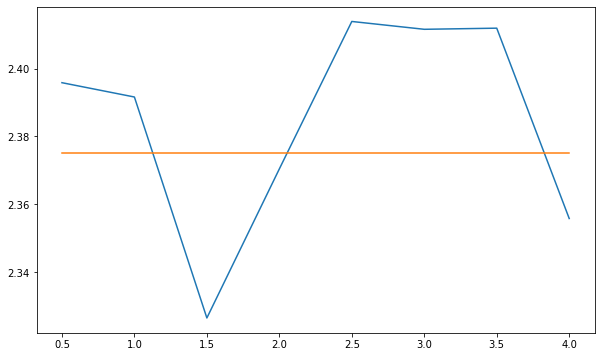

In [34]:
plt.figure(figsize=(10,6))
plt.plot(swap_df.index,swap_df.Float_leg)
plt.plot(swap_df.index,swap_df.Fix_leg)
plt.show()

### Переоценка свопа - ставки упали

In [35]:
T=2 ## новый срок до истечения контракта
start_rate=.0455

In [36]:
disc_rates_y=rates_y(T,start_time,freq, start_rate,step_rate)
disc_rates_y

OrderedDict([(0.5, 0.0455), (1.0, 0.0455), (1.5, 0.0455), (2.0, 0.0455)])

In [37]:
swap.set_rates(disc_rates_y)

In [38]:
swap.get_fix_rate()

OrderedDict([(0.5, 2.3749999999999956),
             (1.0, 2.3749999999999956),
             (1.5, 2.3749999999999956),
             (2.0, 2.3749999999999956),
             (2.5, 2.3749999999999956),
             (3.0, 2.3749999999999956),
             (3.5, 2.3749999999999956),
             (4.0, 2.3749999999999956)])

In [39]:
swap.get_fix_leg()

100.37824536458622

In [40]:
swap.get_float_leg()

100.0

In [41]:
swap.get_swap_value()

-0.3782

In [42]:
swap.get_forward_rates()

OrderedDict([(0.5, 0.0455),
             (1.0, 0.045500000000000096),
             (1.5, 0.045500000000000096),
             (2.0, 0.045500000000000096)])

In [43]:
swap.get_float_check()

100.0

### Переоценка свопа - ставки выросли

In [44]:
T=1.5 ## новый срок до истечения контракта
start_rate=.055

In [45]:
disc_rates_y=rates_y(T,start_time,freq, start_rate,step_rate)
disc_rates_y

OrderedDict([(0.5, 0.055), (1.0, 0.055), (1.5, 0.055)])

In [46]:
swap.set_rates(disc_rates_y)

In [47]:
swap.get_fix_rate()

OrderedDict([(0.5, 2.3749999999999956),
             (1.0, 2.3749999999999956),
             (1.5, 2.3749999999999956),
             (2.0, 2.3749999999999956),
             (2.5, 2.3749999999999956),
             (3.0, 2.3749999999999956),
             (3.5, 2.3749999999999956),
             (4.0, 2.3749999999999956)])

In [48]:
swap.get_fix_leg()

98.93415170059409

In [49]:
swap.get_float_leg()

99.99999999999999

In [50]:
swap.get_swap_value()

1.0658

In [51]:
swap.get_forward_rates()

OrderedDict([(0.5, 0.055),
             (1.0, 0.05500000000000016),
             (1.5, 0.054999999999999494)])

In [52]:
swap.get_float_check()

99.99999999999996

## 4.Currency swap (Валютный своп)

### Заключение своп-соглашения

In [53]:
T=5 #срок

In [54]:
Ex_rate=1.45 # обменный курс

### Валюта A

In [55]:
N_A=100
start_rate_A=.04

In [56]:
disc_rates_A=rates_y(T,start_time,freq, start_rate_A,step_rate)

In [57]:
swap_A=Swap(N_A,freq,disc_rates_A)

In [58]:
swap_A.get_fix_rate()## купон

OrderedDict([(0.5, 2.000000000000002),
             (1.0, 2.000000000000002),
             (1.5, 2.000000000000002),
             (2.0, 2.000000000000002),
             (2.5, 2.000000000000002),
             (3.0, 2.000000000000002),
             (3.5, 2.000000000000002),
             (4.0, 2.000000000000002),
             (4.5, 2.000000000000002),
             (5.0, 2.000000000000002)])

In [59]:
swap_A.get_fix_leg()

100.0

### Валюта B

In [60]:
N_B=N_A*Ex_rate
start_rate_B=.05

In [61]:
disc_rates_B=rates_y(T,start_time,freq, start_rate_B,step_rate)

In [62]:
swap_B=Swap(N_B,freq,disc_rates_B)

In [63]:
swap_B.get_fix_rate()## ставка свопа

OrderedDict([(0.5, 3.6249999999999867),
             (1.0, 3.6249999999999867),
             (1.5, 3.6249999999999867),
             (2.0, 3.6249999999999867),
             (2.5, 3.6249999999999867),
             (3.0, 3.6249999999999867),
             (3.5, 3.6249999999999867),
             (4.0, 3.6249999999999867),
             (4.5, 3.6249999999999867),
             (5.0, 3.6249999999999867)])

In [64]:
swap_B.get_fix_leg()

145.0

### Оценка свопа через форвардные курсы

In [65]:
forward_er=forward_ex_rate(disc_rates_A,disc_rates_B,Ex_rate,freq)
forward_er

OrderedDict([(0.5, 1.4571078431372548),
             (1.0, 1.4642505286428298),
             (1.5, 1.4714282273126473),
             (2.0, 1.4786411107798663),
             (2.5, 1.4858893515189833),
             (3.0, 1.4931731228499585),
             (3.5, 1.5004925989423603),
             (4.0, 1.5078479548195287),
             (4.5, 1.5152393663627617),
             (5.0, 1.5226670103155204)])

In [66]:
coupon_B=swap_B.get_fix_rate()## ставка свопа

In [67]:
## Расчет ставок дисконтирования
l=[]
for key in disc_rates_A:
    l.append(1/(1+disc_rates_A[key]/freq)**(freq*key))
disc_f_A=OrderedDict(zip(disc_rates_A.keys(),l))

In [68]:
sum([coupon_B[key]/forward_er[key]*disc_f_A[key] for key in coupon_B])+N_B/forward_er[T]*disc_f_A[T]

99.99999999999991

### Переоценка валютного свопа

### Переоценка валютного свопа связана с изменением процентных ставок в обеих странах, а также с измением валютного курса

In [69]:
T=2.5 #новый срок

In [70]:
swap_reval=[]
for r_d_delta in [-0.005,0,0.005]:
    rates_A=rates_y(T,start_time,freq, start_rate_A+r_d_delta,step_rate)
    swap_A.set_rates(rates_A)
    for r_f_delta in [-0.005,0,0.005]:
        rates_B=rates_y(T,start_time,freq, start_rate_B+r_f_delta,step_rate)
        swap_B.set_rates(rates_B)
        for ex_r_delta in [-.1,0,0.1]:
            ex_rates=Ex_rate*(1+ex_r_delta)
            reval=swap_A.get_fix_leg()-swap_B.get_fix_leg()/ex_rates
            swap_reval.append([r_d_delta,r_f_delta,ex_r_delta,np.round(reval,4)])

In [71]:
swap_reval_df=pd.DataFrame(swap_reval)

In [72]:
swap_reval_df.columns=['Change_domestic','Change_foreign','Change_ex_rate','Swap_reval']

In [73]:
swap_reval_df

,Change_domestic,Change_foreign,Change_ex_rate,Swap_reval
0,-0.005,-0.005,-0.1,-11.2240
1,-0.005,-0.005,0.0,0.0171
2,-0.005,-0.005,0.1,9.2144
3,-0.005,0.000,-0.1,-9.9241
4,-0.005,0.000,0.0,1.1870
5,-0.005,0.000,0.1,10.2779
6,-0.005,0.005,-0.1,-8.6429
7,-0.005,0.005,0.0,2.3401
8,-0.005,0.005,0.1,11.3262
9,0.000,-0.005,-0.1,-12.4110


## 5.Валютный опцион

### Для моделирования валютного опциона будем использовать формулу Garman–Kohlhagen (вариант формулы Блэка-Шоулза)

### Класс, содержащий методы для моделирования валютного опциона

In [74]:
class GK:
        def __init__(self,Spot,K,r_dom,r_for,T,sigma,t=0,is_call=True):
            self._Spot=Spot
            self._K=K
            self._r_dom=r_dom
            self._r_for=r_for
            self._T=T
            self._sigma=sigma
            self._t=t
            self._is_call=is_call  
       
        def __d_values__(self):
            self._d1=(np.log(self._Spot/self._K)+(self._r_dom-self._r_for+0.5*self._sigma**2)*(self._T-self._t))/(self._sigma*np.sqrt(self._T-self._t))
            self._d2=self._d1-self._sigma*np.sqrt(self._T-self._t)
            
        def __N_d__(self,d_value):
            return stats.norm.cdf(d_value)
        
        def __price__(self):
            return (np.exp(-self._r_for*\
            (self._T-self._t))*self._Spot*self.__N_d__(self._d1)-np.exp(-self._r_dom*\
            (self._T-self._t))*self._K*self.__N_d__(self._d2)) if self._is_call \
            else (np.exp(-self._r_dom*(self._T-self._t))*self._K*self.__N_d__(-self._d2)- np.exp(-self._r_for*\
            (self._T-self._t))*self._Spot*self.__N_d__(-self._d1))
            
        def get_price(self):
            self.__d_values__()
            price=self.__price__()
            return price
        
        def get_delta(self):
            self.__d_values__()
            return self.__N_d__(self._d1) if self._is_call else  self.__N_d__(self._d1)-1
        
        def get_vega(self):
            self.__d_values__()
            return self._Spot*stats.norm.pdf(self._d1)*np.sqrt(self._T-self._t)*np.exp(-self._r_for*\
            (self._T-self._t))/100

### Для примера рассмотрим опцион  GBP/USD с датой до экспирации через два месяца

In [75]:
Spot=1.3140 ## спот-курс
K=1.3150 ## страйк
r_dom=1.88838/100 ## ставка USD
r_for=0.78340/100 ## ставка GBP
sigma=10.82/100 ## волатильность
days=40 ## дней до экспирации
T=days/250 ## дней до экспирации в годах

In [76]:
GK(Spot,K,r_dom,r_for,T,sigma).get_price()

0.02331293707347004

In [77]:
GK(Spot,K,r_dom,r_for,T,sigma).get_delta()

0.5179113686550204

In [78]:
GK(Spot,K,r_dom,r_for,T,sigma).get_vega()

0.00209210294408488

### Загрузка данных о процентных ставках

In [79]:
libor_option=pd.read_csv('/Users/massimozharkovsky/Documents/ML/IFX/LIBOR_option.csv')

In [80]:
libor_option

,Term,USD,GBP
0,1 M,1.7151,0.7066
1,2 M,1.8218,0.7509
2,3 M,1.8905,0.7821
3,4 M,1.8892,0.8082
4,5 M,1.8880,0.8343
5,6 M,1.8868,0.8604
6,7 M,1.8928,0.8782
7,8 M,1.8989,0.8960
8,9 M,1.9049,0.9138
9,10 M,1.9110,0.9315


In [81]:
libor_option.dtypes

Term     object
USD     float64
GBP     float64
dtype: object

### Загрузка данных о рынке опционов, сайт www.investing.com

In [82]:
option=pd.read_csv('/Users/massimozharkovsky/Documents/ML/IFX/GBP_USD_option.csv')

In [83]:
option

,Put_delta,Put,Strikes,Call,Call_delta,Imp_vol,Skew,Vega
0,-0.23,0.00965,1.27,0.05735,0.77,0.1052,0.0148,0.0021
1,-0.27,0.01160,1.28,0.04933,0.72,0.1021,0.0117,0.0022
2,-0.32,0.01416,1.29,0.04183,0.68,0.0991,0.0086,0.0024
3,-0.38,0.01704,1.30,0.03495,0.62,0.0962,0.0058,0.0025
4,-0.44,0.02064,1.31,0.02859,0.56,0.0936,0.0032,0.0026
5,-0.50,0.02492,1.32,0.02282,0.49,0.0913,0.0009,0.0026
6,-0.57,0.03005,1.33,0.01799,0.43,0.0893,-0.0011,0.0026
7,-0.64,0.03574,1.34,0.01371,0.36,0.0876,-0.0028,0.0024
8,-0.70,0.04235,1.35,0.01036,0.29,0.0861,-0.0043,0.0022
9,-0.76,0.04958,1.36,0.00752,0.24,0.0851,-0.0054,0.0021


In [84]:
option.dtypes

Put_delta     float64
Put           float64
Strikes       float64
Call          float64
Call_delta    float64
Imp_vol       float64
Skew          float64
Vega          float64
dtype: object

### Моделирование цен и показателей чувствительности опционов для серии страйков

In [85]:
option_GK=option[['Strikes','Imp_vol']]

In [86]:
Spot=1.3140
days=60
T=days/250

In [87]:
option_GK['Call']=option.apply(lambda row: GK(Spot,row['Strikes'],libor_option.iloc[2,1]/100,libor_option.iloc[2,2]/100,T,row['Imp_vol']).get_price(),axis=1)

In [88]:
option_GK['Call_delta']=option.apply(lambda row: GK(Spot,row['Strikes'],libor_option.iloc[2,1]/100,libor_option.iloc[2,2]/100,T,row['Imp_vol']).get_delta(),axis=1)

In [89]:
option_GK['Put']=option.apply(lambda row: GK(Spot,row['Strikes'],libor_option.iloc[2,1]/100,libor_option.iloc[2,2]/100,T,row['Imp_vol'],is_call=False).get_price(),axis=1)

In [90]:
option_GK['Put_delta']=option.apply(lambda row: GK(Spot,row['Strikes'],libor_option.iloc[2,1]/100,libor_option.iloc[2,2]/100,T,row['Imp_vol'],is_call=False).get_delta(),axis=1)

In [91]:
option_GK['Vega']=option.apply(lambda row: GK(Spot,row['Strikes'],libor_option.iloc[2,1]/100,libor_option.iloc[2,2]/100,T,row['Imp_vol'],is_call=False).get_vega(),axis=1)

In [92]:
option_GK

,Strikes,Imp_vol,Call,Call_delta,Put,Put_delta,Vega
0,1.27,0.1052,0.056567,0.769818,0.009281,-0.230182,0.001952
1,1.28,0.1021,0.048643,0.726518,0.011313,-0.273482,0.002138
2,1.29,0.0991,0.041158,0.676797,0.013782,-0.323203,0.002307
3,1.30,0.0962,0.034182,0.620691,0.016761,-0.379309,0.002445
4,1.31,0.0936,0.027840,0.558603,0.020374,-0.441397,0.002536
5,1.32,0.0913,0.022200,0.492014,0.024688,-0.507986,0.002563
6,1.33,0.0893,0.017309,0.423098,0.029752,-0.576902,0.002516
7,1.34,0.0876,0.013185,0.354528,0.035583,-0.645472,0.002391
8,1.35,0.0861,0.009791,0.288889,0.042144,-0.711111,0.002195
9,1.36,0.0851,0.007142,0.229441,0.049449,-0.770559,0.001948


## 6. Стратегия risk-riversal

### Стратегия состоит в одновременной покупке опциона колл и продаже опциона пут со страйками вне денег 

In [93]:
Strike_call=1.32
Strike_put=1.28

In [94]:
risk_reversal_setup=pd.DataFrame(zip(['Call','Put'],[Strike_call,Strike_put],
[GK(Spot,Strike_call,libor_option.iloc[2,1]/100,libor_option.iloc[2,2]/100,T,option.iloc[5,5]).get_price(),\
GK(Spot,Strike_put,libor_option.iloc[2,1]/100,libor_option.iloc[2,2]/100,T,option.iloc[5,5]).get_price()],['Buy','Sell']),\
                               columns=['Type','Strike','Price','Buy/Sell'])

In [95]:
risk_reversal_setup

,Type,Strike,Price,Buy/Sell
0,Call,1.32,0.022200,Buy
1,Put,1.28,0.046379,Sell


In [96]:
risk_reversal_result=pd.DataFrame(zip(np.arange(1.20,1.40,.01),np.maximum(np.arange(1.20,1.40,.01)-risk_reversal_setup.iloc[0,1],0)-risk_reversal_setup.iloc[0,2],\
-np.maximum(risk_reversal_setup.iloc[1,1]-(np.arange(1.20,1.40,.01)),0)+risk_reversal_setup.iloc[1,2]),columns=['Spot','Call','Put'])

In [97]:
risk_reversal_result['Result']=risk_reversal_result['Call']+risk_reversal_result['Put']

In [98]:
risk_reversal_result

,Spot,Call,Put,Result
0,1.20,-0.0222,-0.033621,-0.055821
1,1.21,-0.0222,-0.023621,-0.045821
2,1.22,-0.0222,-0.013621,-0.035821
3,1.23,-0.0222,-0.003621,-0.025821
4,1.24,-0.0222,0.006379,-0.015821
5,1.25,-0.0222,0.016379,-0.005821
6,1.26,-0.0222,0.026379,0.004179
7,1.27,-0.0222,0.036379,0.014179
8,1.28,-0.0222,0.046379,0.024179
9,1.29,-0.0222,0.046379,0.024179


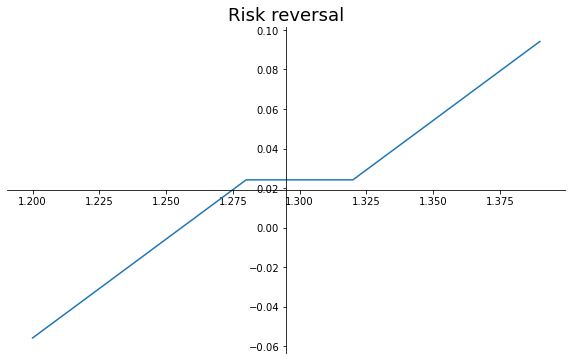

In [99]:
fig=plt.figure(figsize=(10,6))
plt.plot(risk_reversal_result.Spot,risk_reversal_result.Result)
ax=plt.gca()
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_ticks_position('left')
_=plt.title('Risk reversal',fontsize=18)

## 7.Задание

### 1. Построить модель процентного свопа, взяв за основу процентные ставки для какой-либо валюты
### 2. Построить модель валютного свопа, взяв за основу процентные ставки для двух валюты и валютный курс для выбранной пары
### 3. Построить модель валютного опциона, взяв за основу какую-либо валютную пару и сравнить полученные результаты с рыночными данными
### 4. Смоделировать стратегию risk-reversal (опционально)